### Import Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf                  
import tensorflow.nn as nn              
from tensorflow import keras 
from keras.models import Sequential
from keras.regularizers import L1L2
from keras.utils import to_categorical
from keras.initializers import lecun_uniform
from keras.optimizers import Adam
from keras.metrics import categorical_accuracy
from keras.layers import Input, Conv2D, ELU, BatchNormalization, MaxPool2D, MaxPooling2D, Reshape, Dense, CuDNNLSTM, LSTM, add, concatenate, Bidirectional, Dropout, TimeDistributed, Lambda, Permute, Flatten

2023-03-16 14:48:40.472091: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Upload Data

In [2]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

### Shape of data

In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


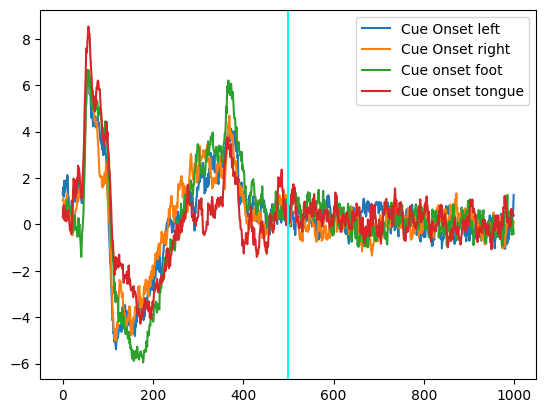

In [4]:
## Loading and visualizing the data

## Loading the dataset


X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that 

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

## Visualizing the data

ch_data = X_train_valid[:,8,:] # extracts the 9th channel from the data


class_0_ind = np.where(y_train_valid == 0) # finds the indices where the label is 0
ch_data_class_0 = ch_data[class_0_ind] # finds the data where label is 0
avg_ch_data_class_0 = np.mean(ch_data_class_0,axis=0) # finds the average representation of the 9th channel when label is 0


class_1_ind = np.where(y_train_valid == 1)
ch_data_class_1 = ch_data[class_1_ind]
avg_ch_data_class_1 = np.mean(ch_data_class_1,axis=0)

class_2_ind = np.where(y_train_valid == 2)
ch_data_class_2 = ch_data[class_2_ind]
avg_ch_data_class_2 = np.mean(ch_data_class_2,axis=0)

class_3_ind = np.where(y_train_valid == 3)
ch_data_class_3 = ch_data[class_3_ind]
avg_ch_data_class_3 = np.mean(ch_data_class_3,axis=0)


plt.plot(np.arange(1000),avg_ch_data_class_0)
plt.plot(np.arange(1000),avg_ch_data_class_1)
plt.plot(np.arange(1000),avg_ch_data_class_2)
plt.plot(np.arange(1000),avg_ch_data_class_3)
plt.axvline(x=500, label='line at t=500',c='cyan')

plt.legend(["Cue Onset left", "Cue Onset right", "Cue onset foot", "Cue onset tongue"])

In [5]:
def data_prep(X,y,sub_sample,average,noise, period):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:period]
    #print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    #print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    #print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    #print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y

In [6]:
## Random splitting and reshaping the data

# generates the indices for splitting the data into training and validation sets

def data_finalize(period, y_test = y_test):

    ind_valid = np.random.choice(2115, 375, replace=False)
    ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

    # Creating the training and validation sets using the generated indices
    (X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
    (y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


    # Preprocessing the dataset with a stride of 2 and padding of 2 on both sides
    x_train,y_train = data_prep(X_train,y_train,2,2,True, period)
    x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True, period)
    X_test_prep,y_test_prep = data_prep(X_test,y_test,2,2,True, period)


    '''print('Shape of testing set:',X_test_prep.shape)
    print('Shape of testing labels:',y_test_prep.shape)

    print('Shape of training set:',x_train.shape)
    print('Shape of validation set:',x_valid.shape)
    print('Shape of training labels:',y_train.shape)
    print('Shape of validation labels:',y_valid.shape)'''



    # Converting the labels to categorical variables for multiclass classification
    y_train = to_categorical(y_train, 4)
    y_valid = to_categorical(y_valid, 4)
    y_test = to_categorical(y_test_prep, 4)
    '''print('Shape of training labels after categorical conversion:',y_train.shape)
    print('Shape of validation labels after categorical conversion:',y_valid.shape)
    print('Shape of test labels after categorical conversion:',y_test.shape)'''

    # Adding width of the segment to be 1
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
    x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
    '''print('Shape of training set after adding width info:',x_train.shape)
    print('Shape of validation set after adding width info:',x_valid.shape)
    print('Shape of test set after adding width info:',x_test.shape) '''


    # Reshaping the training and validation dataset
    x_train = np.swapaxes(x_train, 1,3)
    x_train = np.swapaxes(x_train, 1,2)
    x_valid = np.swapaxes(x_valid, 1,3)
    x_valid = np.swapaxes(x_valid, 1,2)
    x_test = np.swapaxes(x_test, 1,3)
    x_test = np.swapaxes(x_test, 1,2)
    '''print('Shape of training set after dimension reshaping:',x_train.shape)
    print('Shape of validation set after dimension reshaping:',x_valid.shape)
    print('Shape of test set after dimension reshaping:',x_test.shape) '''
    
    return x_train, x_valid, x_test, y_train, y_valid, y_test

### CRNN Model

In [7]:
def CRNN_model(time_period=500):
    
    print("========== period:", time_period, " ==========")
    model = Sequential()
    
    model.add(Conv2D(16, kernel_size=(10,1), padding='same', activation='elu', input_shape=(time_period//2,1,22),use_bias = True, kernel_regularizer = L1L2(l1=0.0, l2=0.5)))
    model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # reduce the spatial dimensions (width and height) of feature maps
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(32, kernel_size=(10, 1), activation='elu', padding='same', use_bias = True, kernel_regularizer = L1L2(l1=0.0, l2=0.5)))
    model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Conv2D(64, kernel_size=(10, 1), activation='elu', padding='same', use_bias = True, kernel_regularizer = L1L2(l1=0.0, l2=0.5)))
    model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Conv2D(128, kernel_size=(10, 1), activation='elu', padding='same', use_bias = True, kernel_regularizer = L1L2(l1=0.0, l2=0.5)))
    model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(TimeDistributed(Flatten()))

    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(epsilon=1e-8, decay=0.01), metrics=['accuracy'])
    
    return model

### Train Data

In [8]:
def train_data(time_period, y_test):
    # different period of time
    
    x_train, x_valid, x_test, y_train, y_valid, y_test = data_finalize(time_period, y_test)

    model = CRNN_model(time_period)
      
    model.fit(x_train,
                 y_train,
                 batch_size=64,
                 epochs=50,
                 validation_data=(x_valid, y_valid), verbose=True)
    
    train_score = model.evaluate(x_train, y_train)
    test_score = model.evaluate(x_valid, y_valid)
    print('train {:s}: {:.3f}%'.format(model.metrics_names[1], train_score[1]*100))
    print('test {:s}: {:.3f}%'.format(model.metrics_names[1], test_score[1]*100))

### Function of time on all subjects

In [9]:
# For the time period between 50 and 500

for smalltime in range (50, 550, 50):
    train_data(smalltime, y_test)

========== period: 50  ==========


2023-03-16 14:48:55.951240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/50
109/109 [==============================] - 7s 20ms/step - loss: 20.9670 - accuracy: 0.2750 - val_loss: 4.0973 - val_accuracy: 0.2400
Epoch 2/50
109/109 [==============================] - 1s 9ms/step - loss: 2.6439 - accuracy: 0.3289 - val_loss: 1.9470 - val_accuracy: 0.2407
Epoch 3/50
109/109 [==============================] - 1s 9ms/step - loss: 1.6959 - accuracy: 0.3468 - val_loss: 1.6071 - val_accuracy: 0.2387
Epoch 4/50
109/109 [==============================] - 1s 9ms/step - loss: 1.4954 - accuracy: 0.3556 - val_loss: 1.5022 - val_accuracy: 0.2613
Epoch 5/50
109/109 [==============================] - 1s 9ms/step - loss: 1.4190 - accuracy: 0.3624 - val_loss: 1.4473 - val_accuracy: 0.3380
Epoch 6/50
109/109 [==============================] - 1s 9ms/step - loss: 1.3916 - accuracy: 0.3750 - val_loss: 1.4070 - val_accuracy: 0.3373
Epoch 7/50
109/109 [==============================] - 1s 9ms/step - loss: 1.3713 - accuracy: 0.3751 - val_loss: 1.3851 - val_accuracy: 0.3580
Epoc

109/109 [==============================] - 1s 11ms/step - loss: 1.4215 - accuracy: 0.4305 - val_loss: 1.3971 - val_accuracy: 0.4333
Epoch 7/50
109/109 [==============================] - 1s 11ms/step - loss: 1.3869 - accuracy: 0.4443 - val_loss: 1.3708 - val_accuracy: 0.4293
Epoch 8/50
109/109 [==============================] - 1s 11ms/step - loss: 1.3568 - accuracy: 0.4701 - val_loss: 1.4053 - val_accuracy: 0.4293
Epoch 9/50
109/109 [==============================] - 1s 11ms/step - loss: 1.3292 - accuracy: 0.4753 - val_loss: 1.2965 - val_accuracy: 0.5087
Epoch 10/50
109/109 [==============================] - 1s 11ms/step - loss: 1.3255 - accuracy: 0.4782 - val_loss: 1.2736 - val_accuracy: 0.4947
Epoch 11/50
109/109 [==============================] - 1s 11ms/step - loss: 1.2956 - accuracy: 0.4973 - val_loss: 1.2761 - val_accuracy: 0.4927
Epoch 12/50
109/109 [==============================] - 1s 11ms/step - loss: 1.2775 - accuracy: 0.5095 - val_loss: 1.2665 - val_accuracy: 0.4927
Epoch 1

109/109 [==============================] - 1s 12ms/step - loss: 1.3171 - accuracy: 0.4815 - val_loss: 1.3478 - val_accuracy: 0.4440
Epoch 12/50
109/109 [==============================] - 1s 12ms/step - loss: 1.3014 - accuracy: 0.4864 - val_loss: 1.3267 - val_accuracy: 0.4760
Epoch 13/50
109/109 [==============================] - 1s 12ms/step - loss: 1.2898 - accuracy: 0.4990 - val_loss: 1.3085 - val_accuracy: 0.4767
Epoch 14/50
109/109 [==============================] - 1s 12ms/step - loss: 1.2612 - accuracy: 0.5200 - val_loss: 1.2981 - val_accuracy: 0.4747
Epoch 15/50
109/109 [==============================] - 1s 12ms/step - loss: 1.2541 - accuracy: 0.5203 - val_loss: 1.2818 - val_accuracy: 0.4827
Epoch 16/50
109/109 [==============================] - 1s 12ms/step - loss: 1.2373 - accuracy: 0.5246 - val_loss: 1.2529 - val_accuracy: 0.5300
Epoch 17/50
109/109 [==============================] - 1s 12ms/step - loss: 1.2159 - accuracy: 0.5420 - val_loss: 1.2781 - val_accuracy: 0.5027
Epoc

109/109 [==============================] - 2s 16ms/step - loss: 1.1449 - accuracy: 0.6024 - val_loss: 1.2518 - val_accuracy: 0.5353
Epoch 17/50
109/109 [==============================] - 2s 16ms/step - loss: 1.1257 - accuracy: 0.6091 - val_loss: 1.2516 - val_accuracy: 0.5573
Epoch 18/50
109/109 [==============================] - 2s 16ms/step - loss: 1.1295 - accuracy: 0.6103 - val_loss: 1.2536 - val_accuracy: 0.5587
Epoch 19/50
109/109 [==============================] - 2s 16ms/step - loss: 1.1008 - accuracy: 0.6191 - val_loss: 1.2501 - val_accuracy: 0.5553
Epoch 20/50
109/109 [==============================] - 2s 16ms/step - loss: 1.0818 - accuracy: 0.6260 - val_loss: 1.3005 - val_accuracy: 0.5367
Epoch 21/50
109/109 [==============================] - 2s 17ms/step - loss: 1.0803 - accuracy: 0.6254 - val_loss: 1.2143 - val_accuracy: 0.5653
Epoch 22/50
109/109 [==============================] - 2s 17ms/step - loss: 1.0608 - accuracy: 0.6376 - val_loss: 1.2643 - val_accuracy: 0.5360
Epoc

109/109 [==============================] - 2s 17ms/step - loss: 1.0551 - accuracy: 0.6409 - val_loss: 1.1547 - val_accuracy: 0.6120
Epoch 22/50
109/109 [==============================] - 2s 17ms/step - loss: 1.0393 - accuracy: 0.6555 - val_loss: 1.1301 - val_accuracy: 0.6020
Epoch 23/50
109/109 [==============================] - 2s 18ms/step - loss: 1.0297 - accuracy: 0.6499 - val_loss: 1.1104 - val_accuracy: 0.6307
Epoch 24/50
109/109 [==============================] - 2s 18ms/step - loss: 1.0176 - accuracy: 0.6648 - val_loss: 1.1057 - val_accuracy: 0.6333
Epoch 25/50
109/109 [==============================] - 2s 17ms/step - loss: 1.0034 - accuracy: 0.6629 - val_loss: 1.0867 - val_accuracy: 0.6333
Epoch 26/50
109/109 [==============================] - 2s 17ms/step - loss: 0.9954 - accuracy: 0.6693 - val_loss: 1.0793 - val_accuracy: 0.6473
Epoch 27/50
109/109 [==============================] - 2s 17ms/step - loss: 0.9599 - accuracy: 0.6859 - val_loss: 1.0934 - val_accuracy: 0.6347
Epoc

109/109 [==============================] - 2s 19ms/step - loss: 0.9422 - accuracy: 0.7066 - val_loss: 1.0767 - val_accuracy: 0.6393
Epoch 27/50
109/109 [==============================] - 2s 19ms/step - loss: 0.9274 - accuracy: 0.7091 - val_loss: 1.0622 - val_accuracy: 0.6540
Epoch 28/50
109/109 [==============================] - 2s 20ms/step - loss: 0.9162 - accuracy: 0.7149 - val_loss: 1.0208 - val_accuracy: 0.6607
Epoch 29/50
109/109 [==============================] - 2s 20ms/step - loss: 0.8857 - accuracy: 0.7276 - val_loss: 1.0347 - val_accuracy: 0.6547
Epoch 30/50
109/109 [==============================] - 2s 20ms/step - loss: 0.9000 - accuracy: 0.7243 - val_loss: 1.0392 - val_accuracy: 0.6600
Epoch 31/50
109/109 [==============================] - 2s 19ms/step - loss: 0.8864 - accuracy: 0.7239 - val_loss: 1.0362 - val_accuracy: 0.6513
Epoch 32/50
109/109 [==============================] - 2s 20ms/step - loss: 0.8731 - accuracy: 0.7329 - val_loss: 1.0445 - val_accuracy: 0.6500
Epoc

109/109 [==============================] - 2s 23ms/step - loss: 0.8495 - accuracy: 0.7398 - val_loss: 1.0241 - val_accuracy: 0.6860
Epoch 32/50
109/109 [==============================] - 2s 22ms/step - loss: 0.8295 - accuracy: 0.7484 - val_loss: 1.0274 - val_accuracy: 0.6947
Epoch 33/50
109/109 [==============================] - 2s 22ms/step - loss: 0.8297 - accuracy: 0.7451 - val_loss: 1.0320 - val_accuracy: 0.6793
Epoch 34/50
109/109 [==============================] - 2s 22ms/step - loss: 0.8187 - accuracy: 0.7533 - val_loss: 0.9898 - val_accuracy: 0.7067
Epoch 35/50
109/109 [==============================] - 2s 23ms/step - loss: 0.8147 - accuracy: 0.7506 - val_loss: 1.0268 - val_accuracy: 0.6913
Epoch 36/50
109/109 [==============================] - 2s 23ms/step - loss: 0.8042 - accuracy: 0.7546 - val_loss: 1.0202 - val_accuracy: 0.6933
Epoch 37/50
109/109 [==============================] - 2s 23ms/step - loss: 0.7883 - accuracy: 0.7636 - val_loss: 0.9747 - val_accuracy: 0.7020
Epoc

109/109 [==============================] - 3s 24ms/step - loss: 0.8019 - accuracy: 0.7592 - val_loss: 1.0142 - val_accuracy: 0.6680
Epoch 37/50
109/109 [==============================] - 3s 23ms/step - loss: 0.7928 - accuracy: 0.7591 - val_loss: 1.0217 - val_accuracy: 0.6667
Epoch 38/50
109/109 [==============================] - 3s 24ms/step - loss: 0.7786 - accuracy: 0.7638 - val_loss: 0.9932 - val_accuracy: 0.6740
Epoch 39/50
109/109 [==============================] - 3s 24ms/step - loss: 0.7747 - accuracy: 0.7609 - val_loss: 0.9624 - val_accuracy: 0.6927
Epoch 40/50
109/109 [==============================] - 3s 24ms/step - loss: 0.7581 - accuracy: 0.7714 - val_loss: 1.0090 - val_accuracy: 0.6727
Epoch 41/50
109/109 [==============================] - 3s 23ms/step - loss: 0.7523 - accuracy: 0.7694 - val_loss: 0.9752 - val_accuracy: 0.6840
Epoch 42/50
109/109 [==============================] - 3s 24ms/step - loss: 0.7537 - accuracy: 0.7744 - val_loss: 1.0043 - val_accuracy: 0.6673
Epoc

109/109 [==============================] - 3s 26ms/step - loss: 0.7332 - accuracy: 0.7918 - val_loss: 0.9901 - val_accuracy: 0.6873
Epoch 42/50
109/109 [==============================] - 3s 25ms/step - loss: 0.7383 - accuracy: 0.7866 - val_loss: 1.0125 - val_accuracy: 0.6833
Epoch 43/50
109/109 [==============================] - 3s 25ms/step - loss: 0.7433 - accuracy: 0.7839 - val_loss: 0.9712 - val_accuracy: 0.6907
Epoch 44/50
109/109 [==============================] - 3s 25ms/step - loss: 0.7343 - accuracy: 0.7876 - val_loss: 0.9638 - val_accuracy: 0.6913
Epoch 45/50
109/109 [==============================] - 3s 25ms/step - loss: 0.7178 - accuracy: 0.7935 - val_loss: 0.9901 - val_accuracy: 0.6860
Epoch 46/50
109/109 [==============================] - 3s 31ms/step - loss: 0.7200 - accuracy: 0.7885 - val_loss: 0.9756 - val_accuracy: 0.6907
Epoch 47/50
109/109 [==============================] - 3s 28ms/step - loss: 0.6997 - accuracy: 0.8016 - val_loss: 0.9789 - val_accuracy: 0.6960
Epoc

109/109 [==============================] - 3s 29ms/step - loss: 0.6727 - accuracy: 0.8095 - val_loss: 0.9949 - val_accuracy: 0.6953
Epoch 47/50
109/109 [==============================] - 3s 28ms/step - loss: 0.6944 - accuracy: 0.8027 - val_loss: 1.0018 - val_accuracy: 0.6913
Epoch 48/50
109/109 [==============================] - 3s 28ms/step - loss: 0.6626 - accuracy: 0.8112 - val_loss: 0.9980 - val_accuracy: 0.7047
Epoch 49/50
109/109 [==============================] - 3s 28ms/step - loss: 0.6624 - accuracy: 0.8116 - val_loss: 1.0300 - val_accuracy: 0.6880
Epoch 50/50
47/47 [==============================] - 0s 6ms/step - loss: 0.9917 - accuracy: 0.7060
train accuracy: 96.839%
test accuracy: 70.600%


In [37]:
# for the time period between 600 and 1100

for largetime in range (600, 1100, 100):
    train_data(largetime, y_test)

========== period: 600  ==========
Epoch 1/50
109/109 [==============================] - 12s 60ms/step - loss: 21.2322 - accuracy: 0.3022 - val_loss: 4.3963 - val_accuracy: 0.2320
Epoch 2/50
109/109 [==============================] - 4s 35ms/step - loss: 2.8001 - accuracy: 0.3924 - val_loss: 2.2538 - val_accuracy: 0.2453
Epoch 3/50
109/109 [==============================] - 4s 35ms/step - loss: 1.7382 - accuracy: 0.4412 - val_loss: 1.9068 - val_accuracy: 0.2487
Epoch 4/50
109/109 [==============================] - 4s 36ms/step - loss: 1.5197 - accuracy: 0.4698 - val_loss: 1.7686 - val_accuracy: 0.3247
Epoch 5/50
109/109 [==============================] - 4s 35ms/step - loss: 1.4110 - accuracy: 0.4978 - val_loss: 1.5475 - val_accuracy: 0.4093
Epoch 6/50
109/109 [==============================] - 4s 34ms/step - loss: 1.3671 - accuracy: 0.5026 - val_loss: 1.4241 - val_accuracy: 0.4733
Epoch 7/50
109/109 [==============================] - 4s 36ms/step - loss: 1.3029 - accuracy: 0.5443 - va

Epoch 6/50
109/109 [==============================] - 4s 40ms/step - loss: 1.3520 - accuracy: 0.5101 - val_loss: 1.3571 - val_accuracy: 0.4940
Epoch 7/50
109/109 [==============================] - 4s 38ms/step - loss: 1.3006 - accuracy: 0.5330 - val_loss: 1.2886 - val_accuracy: 0.5153
Epoch 8/50
109/109 [==============================] - 4s 39ms/step - loss: 1.2671 - accuracy: 0.5553 - val_loss: 1.3009 - val_accuracy: 0.5207
Epoch 9/50
109/109 [==============================] - 4s 39ms/step - loss: 1.2060 - accuracy: 0.5879 - val_loss: 1.2492 - val_accuracy: 0.5507
Epoch 10/50
109/109 [==============================] - 4s 39ms/step - loss: 1.1602 - accuracy: 0.6197 - val_loss: 1.1685 - val_accuracy: 0.6287
Epoch 11/50
109/109 [==============================] - 4s 39ms/step - loss: 1.1291 - accuracy: 0.6374 - val_loss: 1.1280 - val_accuracy: 0.6547
Epoch 12/50
109/109 [==============================] - 4s 39ms/step - loss: 1.0727 - accuracy: 0.6655 - val_loss: 1.1449 - val_accuracy: 0.6

109/109 [==============================] - 7s 66ms/step - loss: 1.0304 - accuracy: 0.6723 - val_loss: 1.0470 - val_accuracy: 0.6487
Epoch 17/50
109/109 [==============================] - 6s 58ms/step - loss: 0.9985 - accuracy: 0.6861 - val_loss: 1.0814 - val_accuracy: 0.6493
Epoch 18/50
109/109 [==============================] - 6s 51ms/step - loss: 0.9757 - accuracy: 0.6970 - val_loss: 1.0161 - val_accuracy: 0.6800
Epoch 19/50
109/109 [==============================] - 5s 48ms/step - loss: 0.9568 - accuracy: 0.7047 - val_loss: 1.0294 - val_accuracy: 0.6733
Epoch 20/50
109/109 [==============================] - 6s 52ms/step - loss: 0.9278 - accuracy: 0.7224 - val_loss: 1.0469 - val_accuracy: 0.6680
Epoch 21/50
109/109 [==============================] - 5s 50ms/step - loss: 0.9265 - accuracy: 0.7185 - val_loss: 1.0169 - val_accuracy: 0.6720
Epoch 22/50
109/109 [==============================] - 5s 48ms/step - loss: 0.9223 - accuracy: 0.7190 - val_loss: 1.0239 - val_accuracy: 0.6827
Epoc